# implements the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import warnings

In [3]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
import os
import json
import numpy as np
import pandas as pd

In [5]:
import sys
sys.path.append('/Users/nicolasf/CODE/paleopy/')

In [6]:
from paleopy.core.proxy import proxy
from paleopy.core.composite import composite
from paleopy.plotting.scalar_plot import scalar_plot

In [7]:
proxies_num = pd.read_excel('./data/ProxiesLIANZSWP.xlsx', sheetname='numerical')

In [8]:
row = proxies_num.iloc[0,]

In [9]:
p = proxy(row.Site, row.Long, row.Lat, row.dataset, row.variable, 'DJF', value = row.Anom, \
          calc_anoms=True, detrend=True)

In [10]:
p.season

'DJF'

In [11]:
# extract the time-series
p.extract_ts()

print("{}{} --> {}{}: {} km".format(p.sitename, p.coords, p.variable, p.extracted_coords.tolist(), p.distance_point))

# calculates the season
p.calculate_season()

p.find_analogs()

Rarotonga(200.18000000000001, -21.23) --> sst[200.0, -22.0]: 87.56368858840081 km


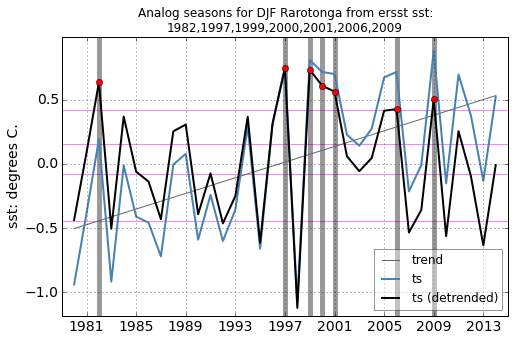

In [12]:
f = p.plot_season_ts()

In [204]:
%%writefile /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py

import os
import sys
import numpy as np
import pandas as pd
import h5py
import json
import seaborn as sns

from ..markov import *
from ..utils import seasons_params

class WR:

    """
    base class for weather regimes calculations and plots
    takes either a proxy or ensemble instance and either 'SW Pacific Regimes' or 'Kidson Types'
    """
    def __init__(self, obj, json_file='./jsons/WRs.json', classification='Kidson Types'):
        super(WR, self).__init__()
              
        # the parent can be either an instance of a `proxy` or `ensemble` class
        self.parent = obj
        
        self.json_file = json_file 
        self.classification = classification
        
        # get the season, and the analog years
        self.season = self.parent.season
        self.analog_years = self.parent.analog_years
        self.detrend = self.parent.detrend
        self.climatology = self.parent.climatology
        if self.parent.description == 'proxy': 
            self.sitename = self.parent.sitename
        
    def _get_WR_json(self): 
        with open(self.json_file, 'r') as f:
            dict_json = json.loads(f.read())
        return dict_json
            
    def _get_WR_ts(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        csv = self.dict_json[self.classification]['WR_TS']
        wr_ts = pd.read_csv(csv, parse_dates=True, index_col=0)
        return wr_ts
    
    def _get_WR_MC(self): 
        if not(hasattr(self, 'dict_json')): 
            self.dict_json = self._get_WR_json()
        f = h5py.File(self.dict_json[self.classification]['Markov Chains'], mode='r')
        MC_probs = f[self.season]['probs'].value
        MC_probs_classes = f[self.season]['probs'].attrs['classes']
        f.close()
        MC_probs_classes = MC_probs_classes.split(',')
        MC_probs = pd.DataFrame(MC_probs, index=MC_probs_classes)
        # reindex so that the index of the MC simulations follows the 
        # order of the types defined in the JSON file
        MC_probs = MC_probs.reindex(self.dict_json[self.classification]['types'])
        # The MC_probs contains the frequencies 
        # of each type in the 1000 simulations
        return MC_probs
        
    def _get_season_ts(self): 
        if not(hasattr(self,'wr_ts')): 
            wr_ts = self._get_WR_ts()
        ts = wr_ts.copy()
        ts.loc[:,'month'] = ts.index.month

        sparams = seasons_params.seasons_params()
        m = list(range(1,13)) + list(range(1,13))
        m = m[(sparams[self.season][1]-sparams[self.season][0]+12):(sparams[self.season][1]+12)]

        # selects the season
        ts_seas = ts[ts['month'].isin(m)]
        ts_seas = ts_seas.drop('month', axis=1)
        
        return ts_seas
    
    def _get_clim_probs(self): 
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ts = ts_seas.ix[str(self.climatology[0]): str(self.climatology[1])].copy()
        types = self.dict_json[self.classification]['types']
        clim_probs = get_probs(ts['type'], types)
        # create a pandas.Series, index are the types
        clim_probs = pd.Series(clim_probs, index=types)
        return clim_probs
        
    def _get_compos_probs(self, analog_years): 
        """
        Arguments
        ---------
        
        analog_years : list
                       list of analog years
                       
        Return
        ------
        
        obs_probs : pandas.Series
                    observed probabilities
        """
        if not(hasattr(self, 'ts_seas')): 
            ts_seas = self._get_season_ts()
        ayears = list(map(str, analog_years))
        ts = ts_seas.copy()
        ts = pd.concat([ts.ix[l] for l in ayears])
        types = self.dict_json[self.classification]['types']
        obs_probs = get_probs(ts['type'], types)
        obs_probs = pd.Series(obs_probs, index=types)
        return obs_probs
    
    def probs_anomalies(self, kind='one', test=True): 
        """
        Arguments
        ---------
        
        kind : string
               if kind == 'one': 
                   either for a `proxy` or for all the years
                   in an `ensemble` as a whole
               if kind == 'many':
                   for each proxy record in an `ensemble` object
                       
        Return
        ------
        
        anoms_probs : pandas.Series
                      probabilities anomalies
        
        """
        
        # get the climatological probabilities, those are always the same
        clim_probs = self._get_clim_probs()
        
        if kind == 'one': 
            obs_probs = self._get_compos_probs(self.analog_years)
            anoms = obs_probs - clim_probs
            if self.parent.description == 'proxy': 
                self.df_anoms = pd.DataFrame(anoms, columns=[self.sitename])
                self.df_probs = pd.DataFrame(obs_probs, columns=[self.sitename])
            else: 
                self.df_anoms = pd.DataFrame(anoms, columns=['ensemble'])
                self.df_probs = pd.DataFrame(obs_probs, columns=['ensemble'])
            # if test, the percentiles values are added as columns to 
            # the df_probs pandas.DataFrame
            if test: 
                MC_probs = self._get_WR_MC()
                for tval in [0.1, 0.9, 0.05, 0.95, 0.01, 0.99]: 
                    c = str(int(tval * 100))
                    self.df_probs.loc[:,c] = MC_probs.T.quantile(tval)
                
        if kind == 'many':
            """
            we can only calculate `many` anomalies 
            if the object passed to the WR instance 
            is an `ensemble` object, raise an exception
            if that is not the case
            """
            if self.parent.description != 'ensemble':
                print("""
                ERROR! cannot calculate `many` anomalies with a proxy
                object: you need to pass an `ensemble` object to the 
                `WR` class
                """)
                raise Exception("KIND ERROR")
            else: 
                d_anoms = {}
                d_probs = {}
                d = self.parent.dict_proxies
                for k in d.keys():
                    obs_probs = self._get_compos_probs(analog_years = d[k]['analog_years'])
                    d_anoms[k] = obs_probs - clim_probs
                    d_probs[k] = obs_probs
                # df_probs contains the ANOMALIES in frequencies (probabilities)
                # for the composite years for each proxy in the ensemble
                # index = types
                # columns = proxies 
                self.df_anoms = pd.DataFrame(d_anoms)
                # df_probs contains the OBSERVED frequencies (probabilities)
                # for the composite years for each proxy in the ensemble
                # index = types
                # columns = proxies
                self.df_probs = pd.DataFrame(d_probs)
            # if test, we add another DataFrame to the object, containing the
            # percentile values coming from the MC simulation
            if test: 
                MC_probs = self._get_WR_MC()
                df_probs_MC = pd.DataFrame()
                for tval in [0.1, 0.9, 0.05, 0.95, 0.01, 0.99]: 
                    c = str(int(tval * 100))
                    df_probs_MC.loc[:,c] = MC_probs.T.quantile(tval)
                self.df_probs_MC = df_probs_MC

Overwriting /Users/nicolasf/CODE/paleopy/paleopy/core/WR.py


In [14]:
from paleopy.core.WR import WR

### try with a proxy object

In [15]:
w = WR(p, classification='SW Pacific Regimes')

In [16]:
obs_probs = w._get_compos_probs(w.analog_years)

In [17]:
w.probs_anomalies()

In [18]:
w.df_probs

,Rarotonga,10,90,5,95,1,99
SW1,0.166403,0.186091,0.226634,0.179576,0.232346,0.171953,0.240352
SW2,0.120444,0.105464,0.136072,0.101242,0.140256,0.093993,0.151326
SW3,0.109350,0.143294,0.181123,0.138326,0.186473,0.129920,0.197554
SW4,0.218700,0.137142,0.170424,0.131830,0.176538,0.123416,0.185716
SW5,0.120444,0.110050,0.139091,0.106209,0.144058,0.099347,0.153244
SW6,0.264659,0.210164,0.255636,0.203668,0.262151,0.191819,0.275888


In [19]:
# f, ax = plt.subplots(figsize=(10,10))
# # ax.plot(w.MC_probs.T.quantile(0.05))
# # ax.plot(w.MC_probs.T.quantile(0.95))
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.1), w.MC_probs.T.quantile(0.9), color='0.1', alpha=0.9)
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.05), w.MC_probs.T.quantile(0.95), color='0.6', alpha=0.6)
# ax.fill_between(range(12), w.MC_probs.T.quantile(0.01), w.MC_probs.T.quantile(0.99), color='0.2', alpha=0.4)

# ax.plot(obs_probs, color='r')
# ax.plot(clim_probs, color='b')


# ax.set_xlim(-0.5, 11.5)
# ax.set_xticks(range(12))
# ax.set_xticklabels(w.dict_json[w.classification]['types']); 

### try with passing an `ensemble` object 

In [186]:
jsons = './jsons/proxies/'

In [187]:
from paleopy.core.ensemble import ensemble

In [188]:
ens = ensemble(jsons, season='DJF')

In [189]:
# w = WR(ens, classification='SW Pacific Regimes')
w = WR(ens, classification='Kidson Types')

In [190]:
w.parent.description

'ensemble'

In [191]:
w.climatology

[1981, 2010]

In [192]:
w.probs_anomalies()

In [193]:
w.df_probs

,ensemble,10,90,5,95,1,99
T,0.127715,0.099733,0.125716,0.097039,0.129538,0.090940,0.135659
SW,0.104793,0.087887,0.107757,0.085575,0.110451,0.081383,0.116164
TNW,0.093079,0.082919,0.101261,0.080245,0.104719,0.075659,0.111200
TSW,0.071107,0.062629,0.081773,0.060374,0.084830,0.055403,0.089423
H,0.078959,0.069507,0.089797,0.066870,0.092854,0.062667,0.097062
HNW,0.044513,0.040122,0.052732,0.037830,0.055025,0.035533,0.057700
W,0.034699,0.029041,0.040887,0.027895,0.042797,0.024838,0.045480
HSE,0.153612,0.157050,0.191823,0.153592,0.197172,0.143672,0.208258
HE,0.056797,0.053114,0.066527,0.051204,0.068399,0.048907,0.071081
NE,0.091053,0.074131,0.096332,0.071074,0.100115,0.064574,0.106622


In [194]:
w.probs_anomalies(kind='many')

In [195]:
w.df_anoms

,Amedee,Avoca,Browning Creek,Cameron,Caples,Cass,Clarke,Crow,Falls Creek,Frances,...,Jollie,Mistake,Oroko,Pear Drop,Pyke,Rarotonga,Taramakau,Temple,Turnbull,Washington Isl.
T,0.029707,0.013635,0.039231,0.007108,0.049830,0.015020,0.035589,-0.004138,0.018390,0.032425,...,-0.004138,-0.005717,-0.005717,0.038754,0.008881,-0.011721,0.013240,0.037172,0.029707,-0.026255
SW,0.033961,-0.001115,-0.027943,0.009805,0.014552,-0.002853,0.014552,0.028590,0.002054,0.024046,...,0.028590,0.015952,0.022271,0.012970,0.003639,-0.001115,0.033329,0.008223,-0.012070,-0.029862
TNW,-0.028122,0.005058,0.005211,-0.004589,0.000158,0.000158,0.000158,0.006332,-0.001282,-0.015665,...,0.006332,0.001593,-0.003147,0.009651,-0.015545,-0.021884,0.007912,0.022310,0.011560,0.017390
TSW,-0.011828,-0.002412,0.000871,0.006974,-0.010431,0.006974,-0.008849,0.006851,-0.000827,-0.018343,...,0.006851,0.008431,-0.004207,-0.016760,0.007097,0.026114,-0.007367,-0.008849,0.004045,0.030548
H,-0.002385,0.007001,-0.013496,0.013192,-0.001049,0.003698,0.008445,-0.009072,0.002246,0.014774,...,-0.009072,-0.009072,0.016204,-0.007378,0.008585,-0.005678,-0.001174,-0.004213,-0.005559,-0.043828
HNW,0.008530,-0.002649,0.000594,0.005195,0.003613,0.003613,-0.012210,-0.009103,0.005275,0.009942,...,-0.009103,-0.007523,0.013014,-0.001134,0.003691,0.011615,-0.004364,-0.016957,-0.008930,-0.009103
W,-0.006153,0.008064,-0.001391,0.009579,0.001668,-0.003079,-0.003079,-0.001549,0.006480,0.003250,...,-0.001549,-0.001549,0.001610,0.003250,-0.001444,0.003310,-0.004709,-0.006244,0.006545,-0.004709
HSE,-0.011500,-0.030779,-0.001976,-0.045250,-0.027845,-0.010440,-0.032592,-0.032819,-0.035533,-0.021516,...,-0.032819,-0.024920,-0.032819,-0.027845,-0.022855,-0.008592,-0.034399,-0.038921,-0.036897,0.043010
HE,-0.001854,-0.013040,-0.008203,-0.009951,-0.017862,-0.000457,-0.002039,0.007347,-0.011455,-0.008368,...,0.007347,0.012086,0.015246,-0.008368,0.004393,-0.011455,-0.005291,0.001125,-0.008203,-0.006871
NE,-0.021952,0.015985,0.003445,0.007915,0.000004,-0.004743,0.015827,0.017249,0.004891,-0.011072,...,0.017249,0.014090,-0.004868,0.007915,-0.010957,-0.012541,0.009350,0.030067,0.020905,0.015669


In [196]:
import seaborn as sns

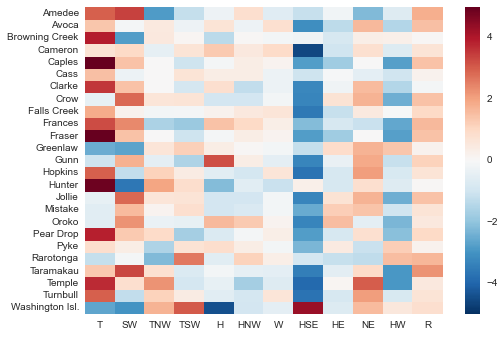

In [197]:
sns.heatmap(w.df_anoms.T*100)

In [198]:
w.df_probs_MC

,10,90,5,95,1,99
T,0.099733,0.125716,0.097039,0.129538,0.090940,0.135659
SW,0.087887,0.107757,0.085575,0.110451,0.081383,0.116164
TNW,0.082919,0.101261,0.080245,0.104719,0.075659,0.111200
TSW,0.062629,0.081773,0.060374,0.084830,0.055403,0.089423
H,0.069507,0.089797,0.066870,0.092854,0.062667,0.097062
HNW,0.040122,0.052732,0.037830,0.055025,0.035533,0.057700
W,0.029041,0.040887,0.027895,0.042797,0.024838,0.045480
HSE,0.157050,0.191823,0.153592,0.197172,0.143672,0.208258
HE,0.053114,0.066527,0.051204,0.068399,0.048907,0.071081
NE,0.074131,0.096332,0.071074,0.100115,0.064574,0.106622


In [199]:
w.df_probs

,Amedee,Avoca,Browning Creek,Cameron,Caples,Cass,Clarke,Crow,Falls Creek,Frances,...,Jollie,Mistake,Oroko,Pear Drop,Pyke,Rarotonga,Taramakau,Temple,Turnbull,Washington Isl.
T,0.141270,0.125198,0.150794,0.118671,0.161392,0.126582,0.147152,0.107425,0.129952,0.143987,...,0.107425,0.105845,0.105845,0.150316,0.120444,0.099842,0.124803,0.148734,0.141270,0.085308
SW,0.133333,0.098257,0.071429,0.109177,0.113924,0.096519,0.113924,0.127962,0.101426,0.123418,...,0.127962,0.115324,0.121643,0.112342,0.103011,0.098257,0.132701,0.107595,0.087302,0.069510
TNW,0.063492,0.096672,0.096825,0.087025,0.091772,0.091772,0.091772,0.097946,0.090333,0.075949,...,0.097946,0.093207,0.088468,0.101266,0.076070,0.069731,0.099526,0.113924,0.103175,0.109005
TSW,0.058730,0.068146,0.071429,0.077532,0.060127,0.077532,0.061709,0.077409,0.069731,0.052215,...,0.077409,0.078989,0.066351,0.053797,0.077655,0.096672,0.063191,0.061709,0.074603,0.101106
H,0.077778,0.087163,0.066667,0.093354,0.079114,0.083861,0.088608,0.071090,0.082409,0.094937,...,0.071090,0.071090,0.096367,0.072785,0.088748,0.074485,0.078989,0.075949,0.074603,0.036335
HNW,0.053968,0.042789,0.046032,0.050633,0.049051,0.049051,0.033228,0.036335,0.050713,0.055380,...,0.036335,0.037915,0.058452,0.044304,0.049128,0.057052,0.041074,0.028481,0.036508,0.036335
W,0.028571,0.042789,0.033333,0.044304,0.036392,0.031646,0.031646,0.033175,0.041204,0.037975,...,0.033175,0.033175,0.036335,0.037975,0.033281,0.038035,0.030016,0.028481,0.041270,0.030016
HSE,0.165079,0.145800,0.174603,0.131329,0.148734,0.166139,0.143987,0.143760,0.141046,0.155063,...,0.143760,0.151659,0.143760,0.148734,0.153724,0.167987,0.142180,0.137658,0.139683,0.219589
HE,0.058730,0.047544,0.052381,0.050633,0.042722,0.060127,0.058544,0.067930,0.049128,0.052215,...,0.067930,0.072670,0.075829,0.052215,0.064976,0.049128,0.055292,0.061709,0.052381,0.053712
NE,0.061905,0.099842,0.087302,0.091772,0.083861,0.079114,0.099684,0.101106,0.088748,0.072785,...,0.101106,0.097946,0.078989,0.091772,0.072900,0.071315,0.093207,0.113924,0.104762,0.099526


In [200]:
pd.concat([w.df_probs.iloc[:,i] > w.df_probs_MC['90'] for i in range(w.df_probs.shape[0])], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11
T,True,False,True,False,True,True,True,False,True,True,True,False
SW,True,False,False,True,True,False,True,True,False,True,True,False
TNW,False,False,False,False,False,False,False,False,False,False,False,False
TSW,False,False,False,False,False,False,False,False,False,False,False,True
H,False,False,False,True,False,False,False,False,False,True,False,False
HNW,True,False,False,False,False,False,False,False,False,True,False,False
W,False,True,False,True,False,False,False,False,True,False,False,False
HSE,False,False,False,False,False,False,False,False,False,False,False,False
HE,False,False,False,False,False,False,False,True,False,False,False,True
NE,False,True,False,False,False,False,True,True,False,False,False,True


In [201]:
w.df_probs_MC

,10,90,5,95,1,99
T,0.099733,0.125716,0.097039,0.129538,0.090940,0.135659
SW,0.087887,0.107757,0.085575,0.110451,0.081383,0.116164
TNW,0.082919,0.101261,0.080245,0.104719,0.075659,0.111200
TSW,0.062629,0.081773,0.060374,0.084830,0.055403,0.089423
H,0.069507,0.089797,0.066870,0.092854,0.062667,0.097062
HNW,0.040122,0.052732,0.037830,0.055025,0.035533,0.057700
W,0.029041,0.040887,0.027895,0.042797,0.024838,0.045480
HSE,0.157050,0.191823,0.153592,0.197172,0.143672,0.208258
HE,0.053114,0.066527,0.051204,0.068399,0.048907,0.071081
NE,0.074131,0.096332,0.071074,0.100115,0.064574,0.106622


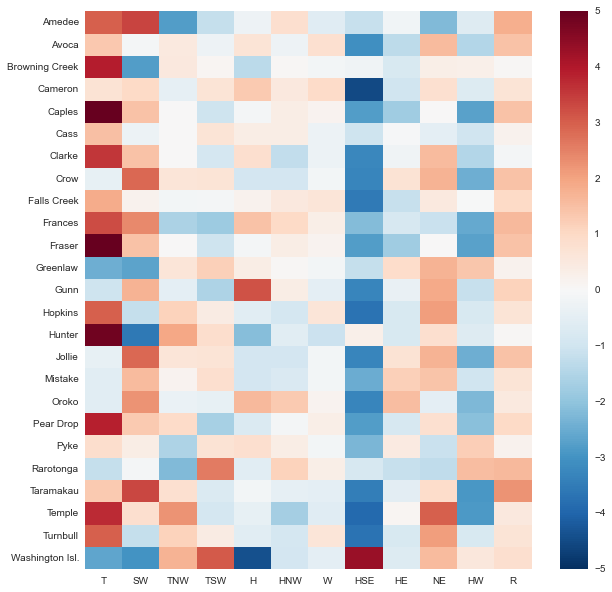

In [202]:
df_anoms = w.df_anoms * 100
df_anoms = df_anoms.T
anoms = df_anoms.values
vmax = np.ceil(np.abs([anoms.min(),anoms.max()]).max())
vmin = -1 * vmax

### ==============================================================================================================
### figure

width, height = plt.figaspect(anoms)
fig, ax = plt.subplots(figsize=(10, 10))

#fig = plt.figure(figsize=(12,10))
#ax = fig.add_subplot(gs[2::,2::])

X = np.arange(df_anoms.shape[1])
Y = np.arange(0.5, df_anoms.shape[0] + 0.5)[::-1]
# im = ax.pcolormesh(X, Y, anoms,vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) 
im = ax.pcolormesh(anoms[::-1,:],vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) 

ax.set_yticks(np.arange(0.5, anoms.shape[0] + 0.5))
ax.set_yticklabels(df_anoms.index[::-1])

ax.set_xticks(np.arange(0.5, anoms.shape[1] + 0.5))
ax.set_xticklabels(df_anoms.columns)


cb = plt.colorbar(im)